
# Descriptive Operations & CRM KPIs

## 1. Order & Fulfillment Overview

* Q1: What are the daily, weekly, and monthly order volumes?

* Q2: What is the average fulfillment cycle time (order → delivery) over time?

* Q3: What percentage of orders are delivered on time (OTD %)?

* NEW Q4: How does return rate vary by product category and month?

## 2. Inventory & Returns

* Q5: How do inventory levels fluctuate relative to order peaks?


## 3. High-Level CRM Descriptives

* Q6: Overall open rate, click-through rate (CTR) and unsubscribe rate by channel.

* Q7: Open/CTR/unsubscribe broken out by customer segment (new vs. repeat vs. inactive).

* Q8: Open/CTR/unsubscribe by age group and region.



In [59]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

customer_df = pd.read_csv('../data/customers.csv')
churn_labels_df = pd.read_csv('../data/churn_labels.csv')
marketing_events_df = pd.read_csv('../data/marketing_events.csv')
subscription_events_df= pd.read_csv('../data/subscriptions.csv')
support_tickets_df= pd.read_csv('../data/support_tickets.csv')
time_dim_df= pd.read_csv('../data/time_dim.csv')
usage_events_df = pd.read_csv('../data/usage_events.csv')




Preparation of the data (join operations)

In [ ]:
## join all customers with churn labels 
customer_churn_df= pd.merge(customer_df,churn_labels_df,on='customer_id',how='left')




,customer_id,segment,signup_date,annual_revenue,country,industry,company_size,is_active,churn_date,churn_reason,churn_type,last_active_date,months_active,is_at_risk_flag,score
0,5aa0cb39-c3f9-45fd-bc69-7a6480f60480,SME,2024-11-21,144405.95,United Kingdom,E-commerce,100,True,NaN,NaN,voluntary,2025-07-24,8.2,False,67
1,406a193e-34d2-46b7-b45a-d62593a791a9,Enterprise,2024-12-20,52111949.49,France,EdTech,10657,True,NaN,NaN,involuntary,2025-07-24,7.2,False,71
2,d67c5905-bbbf-452a-8776-6859806214ac,Mid-market,2025-05-08,38715634.88,United Kingdom,Cybersecurity,514,False,NaN,NaN,involuntary,2025-07-24,2.6,False,89
3,1fa4581a-9bef-438a-9470-8ca37e51e1bf,SME,2024-11-01,245649.06,Germany,Healthcare,100,True,2025-02-26,Lack of Desired Outcomes,involuntary,2025-02-26,3.9,False,84
4,a73dfa2d-076b-4c7d-9583-bfbec0a9fdf0,SME,2025-05-13,401291.00,United Kingdom,Cybersecurity,30,True,NaN,NaN,involuntary,2025-07-24,2.4,False,90


In [61]:
churned= customer_churn_df[customer_churn_df['churn_date'].notnull()].copy()
churned['churn_date'] = pd.to_datetime(churned['churn_date']).dt.date
time_dim_df['date'] = pd.to_datetime(time_dim_df['date']).dt.date




In [62]:

## Missing dates in time_dim need to populate it correctly first 
# Step 1: Calculate required date range
min_date = churned['churn_date'].min()
max_date = churned['churn_date'].max()

# Step 2: Generate full calendar
date_range = pd.date_range(start=min_date, end=max_date, freq='D')
time_dim_df = pd.DataFrame({'date': date_range})
time_dim_df['date'] = time_dim_df['date'].dt.date  # Ensure matches churn_date format

# Step 3: Add time features
time_dim_df['month'] = pd.to_datetime(time_dim_df['date']).dt.month
time_dim_df['day_of_week'] = pd.to_datetime(time_dim_df['date']).dt.dayofweek
time_dim_df['is_weekend'] = time_dim_df['day_of_week'].isin([5, 6])
time_dim_df['quarter'] = pd.to_datetime(time_dim_df['date']).dt.quarter
time_dim_df['week_number'] = pd.to_datetime(time_dim_df['date']).dt.isocalendar().week
time_dim_df['day_of_month'] = pd.to_datetime(time_dim_df['date']).dt.day
time_dim_df['is_month_end'] = pd.to_datetime(time_dim_df['date']).dt.is_month_end
time_dim_df['is_year_start'] = pd.to_datetime(time_dim_df['date']).dt.is_year_start
time_dim_df['is_holiday'] = False  # Placeholder — update if you have holiday logic

# Optional: Season mapping
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

time_dim_df['season'] = pd.to_datetime(time_dim_df['date']).apply(get_season)


In [63]:
churned= churned.merge(time_dim_df,left_on='churn_date',right_on='date', how='left')

### 1. Churn & Revenue Baselines

Step 1: preparing customer_df 

In [64]:
customer_df['signup_date'] = pd.to_datetime(customer_df['signup_date'])
customer_df['year'] = customer_df['signup_date'].dt.year
customer_df['month'] = customer_df['signup_date'].dt.month
customer_df['quarter'] = customer_df['signup_date'].dt.quarter


Step 2: calculate cumulative active customers by period and segment 

In [65]:
monthly_active= (
    customer_df
    .groupby(['year','month','segment'])['customer_id']
    .nunique()
    .groupby(level=0)# group by year and segment for cumulative sum by month
    .cumsum()
    .reset_index()
    .sort_values(['year','month','segment'])
    .rename(columns={'customer_id':'active_customers'})

    
)

monthly_active['period'] = pd.to_datetime(
    monthly_active[['year', 'month']].assign(day=1)
)
monthly_active = (
    monthly_active
    .sort_values(['segment', 'period'])
)

monthly_active['active_customers'] = (
    monthly_active
    .groupby('segment')['active_customers']
    .cumsum()
)




Quaterly active customers 

In [66]:
quarterly_active=(
    customer_df
    .groupby(['year','quarter','segment'])['customer_id']
    .nunique()
    .groupby(level=0)
    .cumsum()
    .reset_index()
    .sort_values(['year','quarter','segment'])
    .rename(columns={'customer_id':'active_customers'})

)


quarterly_active['period'] = pd.PeriodIndex(
    year=quarterly_active['year'],
    quarter=quarterly_active['quarter'],
    freq='Q'
)


quarterly_active = quarterly_active.sort_values(['segment', 'period'])
quarterly_active['active_customers'] = (
    quarterly_active
    .groupby('segment')['active_customers']
    .cumsum()
)



C:\Users\yeahm\AppData\Local\Temp\ipykernel_45584\2685286344.py:14: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  quarterly_active['period'] = pd.PeriodIndex(


Merge churn counts with active customers and compute churn rate 

In [67]:
## for montly churn rate 

monthly_churn['period']= pd.to_datetime(monthly_churn[['year','month']].assign(day=1))


monthly_active['period'] = pd.to_datetime(monthly_active[['year','month']].assign(day=1))


monthly = monthly_churn.merge(
    monthly_active,
    on=['segment','period'],how='left')


monthly['churn_rate']= monthly['churned_customers']/monthly['active_customers']



In [ ]:
monthly_churn_final = monthly.rename(columns={
    'year_x': 'year',
    'month_x': 'month'
})

monthly_churn_final = monthly_churn_final[[
    'year', 'month', 'segment','period', 'churned_customers', 'active_customers', 'churn_rate'
]]




,year,month,segment,period,churned_customers,active_customers,churn_rate
0,2024,8,Mid-market,2024-08-01,2,692.0,0.002890
1,2024,8,SME,2024-08-01,3,1281.0,0.002342
2,2024,9,Mid-market,2024-09-01,1,1664.0,0.000601
3,2024,9,SME,2024-09-01,3,2562.0,0.001171
4,2024,10,Mid-market,2024-10-01,1,3077.0,0.000325
5,2024,10,SME,2024-10-01,11,4289.0,0.002565
6,2024,11,Enterprise,2024-11-01,1,4430.0,0.000226
7,2024,11,Mid-market,2024-11-01,1,4926.0,0.000203
8,2024,11,SME,2024-11-01,23,6434.0,0.003575
9,2024,12,Mid-market,2024-12-01,8,7195.0,0.001112


For quarterly churn rate 

In [69]:
# For quarterly churn

quarterly_churn['year'] = quarterly_churn['year'].astype(int)
quarterly_churn['quarter'] = quarterly_churn['quarter'].astype(int)

quarterly_churn['period'] = pd.PeriodIndex(
    quarterly_churn['year'].astype(str) + 'Q' + quarterly_churn['quarter'].astype(str),
    freq='Q'
)

# Same fix for active customers
quarterly_active['year'] = quarterly_active['year'].astype(int)
quarterly_active['quarter'] = quarterly_active['quarter'].astype(int)

quarterly_active['period'] = pd.PeriodIndex(
    quarterly_active['year'].astype(str) + '-Q' + quarterly_active['quarter'].astype(str),
    freq='Q'
)



quarterly = quarterly_churn.merge(
    quarterly_active,
    on=['segment', 'period'],
    how='left'
)

quarterly['churn_rate'] = quarterly['churned_customers'] / quarterly['active_customers']



In [70]:

quarterly_churn_final = quarterly.rename(columns={'year_x':'year','quarter_x':'quarter'})


quarterly_churn_final = quarterly_churn_final[['year','quarter','segment','churned_customers','period','active_customers','churn_rate']]

#### Quarterly churn rate overall and by segment (SME, mid‑market, enterprise)
To calculate churn rate:
- Counted unique churned customers per time period.
- Counted active customers per segment cumulatively.
- Calculated churn rate = churned / active.

In [71]:


quarterly_churn_final.head()

,year,quarter,segment,churned_customers,period,active_customers,churn_rate
0,2024,3,Mid-market,3,2024Q3,383.0,0.007833
1,2024,3,SME,6,2024Q3,1281.0,0.004684
2,2024,4,Enterprise,1,2024Q4,1446.0,0.000692
3,2024,4,Mid-market,10,2024Q4,2042.0,0.004897
4,2024,4,SME,65,2024Q4,3900.0,0.016667


#### Line Plot: Churn Rate Over Time (Quarterly & Monthly)
Quarterly Churn Rate:

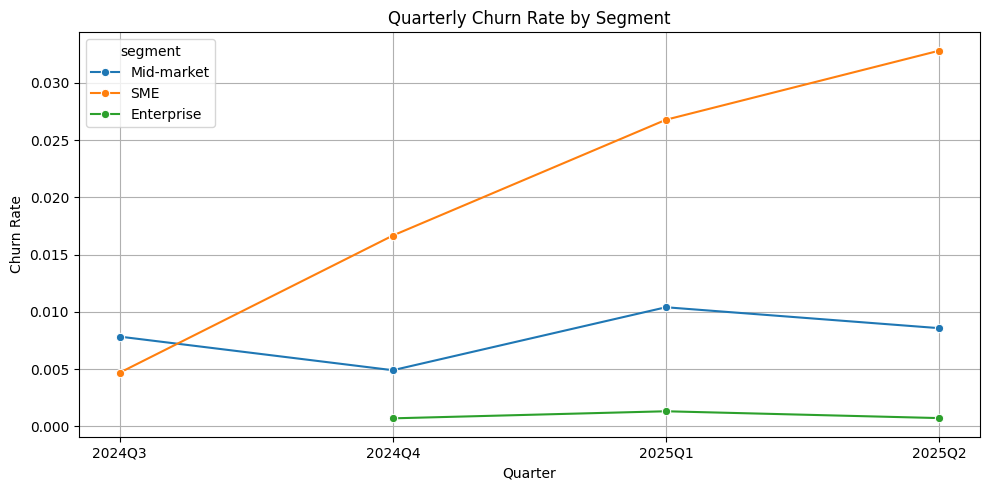

In [74]:
quarterly_churn_final['period'] = quarterly_churn_final['period'].astype(str)


plt.figure(figsize=(10, 5))
sns.lineplot(data=quarterly_churn_final, x='period', y='churn_rate', hue='segment', marker='o')
plt.title('Quarterly Churn Rate by Segment')
plt.ylabel('Churn Rate')
plt.xlabel('Quarter')
plt.grid(True)
plt.tight_layout()
plt.show()


### Monthly churn rate overall and by segment (SME, mid‑market, enterprise)

In [58]:
monthly_churn_final.head()

,year,month,segment,period,churned_customers,active_customers,churn_rate
0,2024,8,Mid-market,2024-08-01,2,692.0,0.002890
1,2024,8,SME,2024-08-01,3,1281.0,0.002342
2,2024,9,Mid-market,2024-09-01,1,1664.0,0.000601
3,2024,9,SME,2024-09-01,3,2562.0,0.001171
4,2024,10,Mid-market,2024-10-01,1,3077.0,0.000325


Monthly Churn Rate:

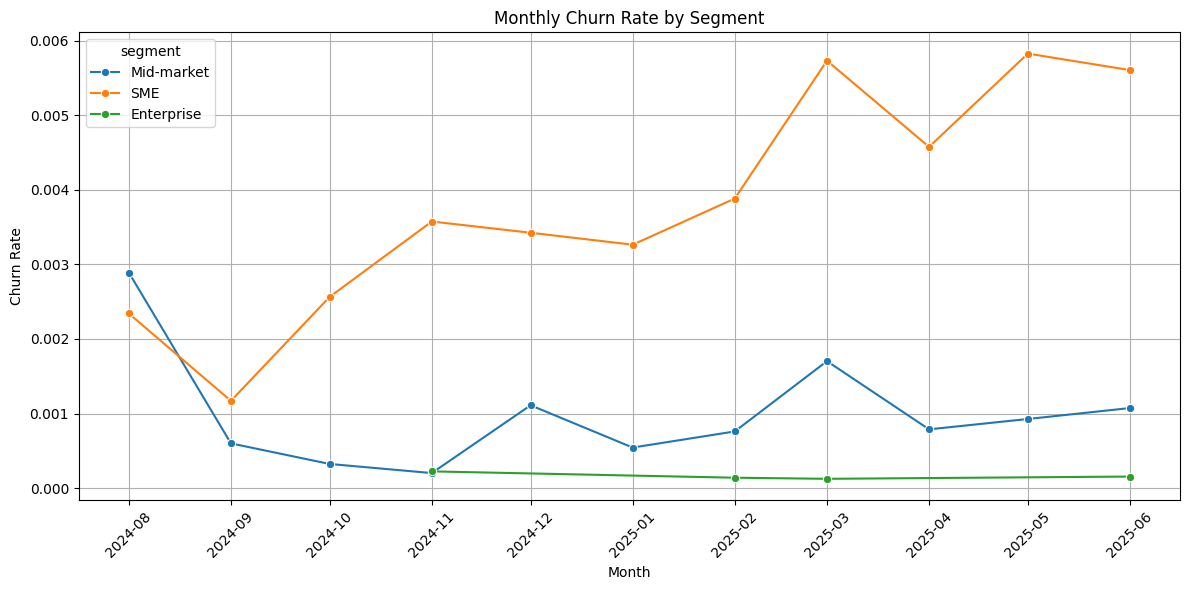

In [75]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_churn_final, x='period', y='churn_rate', hue='segment', marker='o')
plt.title('Monthly Churn Rate by Segment')
plt.ylabel('Churn Rate')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()